# RL Assignment

### By Nitin Madhavan

### Problem Statement

In this assignment, you need to build an RL agent that learns to play Numerical Tic-Tac-Toe with odd numbers (the agent will always make the first move). You need to train your agent using Q-Learning. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. If your agent wins the game, it gets 10 points, if the environment wins, the agent loses 10 points. And if the game ends in a draw, it gets 0. Also, you want the agent to win in as few moves as possible, so for each move, it gets a -1 point.

### Tic-Tac-Toe Agent

In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values
        


#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
import arrow

## MDP Framework of Numerical Tic-Tac-Toe

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

# Call Environment as env
env = TicTacToe()

def valid_actions(state):
    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    if z > epsilon:
        # Fetch max Q value
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        # Generate Random Action
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
sample_q_values = [('x-x-x-x-6-x-x-x-5',(2,7)), 
                   ('x-x-x-x-9-x-6-x-x',(1,7)),
                   ('x-6-5-x-2-x-x-3-x',(0,7)), 
                   ('7-x-5-x-2-x-x-x-6',(1,3))]
    
def initialise_tracking_states():
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []  

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

## Training the Agent (Q-Learning)

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 15000000
#EPISODES = 20000

LR = 0.01   # learning rate
GAMMA = 0.91

max_epsilon = 1.0
min_epsilon = 0.001

threshold = 2000      
policy_threshold = 30000

### Q-update loop ---write your code here

In [12]:
start_time = arrow.now()

for episode in tqdm(range(EPISODES)):
    env = TicTacToe()
    curr_state = env.state
    isTerminated = False
    add_to_dict(curr_state)
    total_reward = 0

    while not isTerminated:
        current_state_ele = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, isTerminated = env.step(curr_state, curr_action)

        next_state_ele = Q_state(next_state)
        add_to_dict(next_state)

        if isTerminated:
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward - Q_dict[current_state_ele][curr_action]))
        else:
            max_next = max(Q_dict[next_state_ele],
                           key=Q_dict[next_state_ele].get)
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward + (GAMMA * (Q_dict[next_state_ele][max_next]))) -
                Q_dict[current_state_ele][curr_action])

        curr_state = next_state
        total_reward += reward

    # Tracking the Q-Values here
    
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    # Saving the Policy here
    
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')

elapsed_time = arrow.now() - start_time
save_obj(States_track, 'States_tracked')
save_obj(Q_dict, 'Policy')
print(elapsed_time)

100%|██████████| 15000000/15000000 [3:59:41<00:00, 1043.01it/s]  


3:59:41.539182


## Q-values Tracking

#### Check the Q-dictionary

In [13]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 5.186104479714361,
              (0, 3): 4.6725784627037585,
              (0, 5): 3.9367174919808487,
              (0, 7): -0.21284418786767847,
              (0, 9): -0.415873797051338,
              (1, 1): 3.2051948439021767,
              (1, 3): 3.556624765836265,
              (1, 5): 7.099653145295374,
              (1, 7): -0.9028285455463135,
              (1, 9): 0.20828416210630502,
              (2, 1): 4.668211412528622,
              (2, 3): 3.8347332182233154,
              (2, 5): 2.790929602678766,
              (2, 7): 0.3257906099005089,
              (2, 9): 0.5605820097262616,
              (3, 1): 3.452261599732189,
              (3, 3): 3.5971510741635297,
              (3, 5): 3.391758793673496,
              (3, 7): 0.03464495557964564,
              (3, 9): 0.30258991047223066,
              (4, 1): 4.422123387207288,
              (4, 3): 3.896998581009903,
              (4, 5): 4.090946170081521,

In [14]:
len(Q_dict)

1208939

In [15]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

x-x-x-x-6-x-x-x-5 (2, 7)
x-x-x-x-9-x-6-x-x (1, 7)
x-6-5-x-2-x-x-3-x (0, 7)
7-x-5-x-2-x-x-x-6 (1, 3)


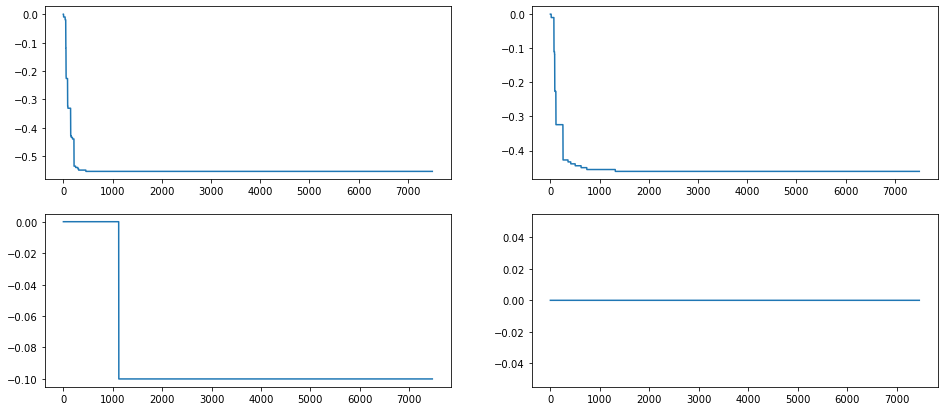

In [16]:

plt.figure(0, figsize=(16,7))

for idx, sample_val in enumerate(sample_q_values):   
    print(sample_val[0], sample_val[1])
    x_axis = np.asarray(range(0, len(States_track[sample_val[0]][sample_val[1]])))
    plt.subplot(221 + idx)
    plt.plot(x_axis,np.asarray(States_track[sample_val[0]][sample_val[1]]))
    plt.show

### Epsilon - decay check

In [17]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

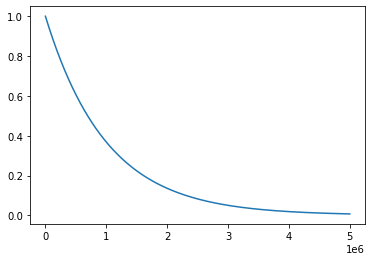

In [18]:
plt.plot(time, epsilon)
plt.show()